# Baseline : Régression Logistique - Détection de Fraude

## Objectifs de ce notebook
1. **Charger les données préparées** depuis l'étape précédente
2. **Préparer les features** pour la modélisation (encodage final)
3. **Diviser les données** en train et validation
4. **Entraîner une Régression Logistique** comme baseline
5. **Évaluer le modèle** avec F1-Score et autres métriques
6. **Analyser les résultats** (matrice de confusion, importance des features)
7. **Gérer le déséquilibre des classes** avec class_weight

---


## 1. Import des bibliothèques


In [1]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_auc_score, roc_curve)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliothèques importées avec succès")


Bibliothèques importées avec succès


**Note :** Ce bloc importe toutes les bibliothèques nécessaires pour la modélisation. Scikit-learn est utilisé pour la régression logistique, la division des données, le scaling, et les métriques d'évaluation. Les métriques importantes incluent le F1-Score (métrique principale selon le sujet), ainsi que la précision, le rappel, et l'AUC-ROC pour une évaluation complète.


## 2. Chargement des données préparées


In [2]:
# Chargement des données préparées
train_df = pd.read_csv('ressources/train_prepared.csv')
test_df = pd.read_csv('ressources/test_prepared.csv')

print("=" * 60)
print("CHARGEMENT DES DONNEES PREPAREES")
print("=" * 60)
print(f"\nTrain set: {train_df.shape}")
print(f"Test set: {test_df.shape}")
print(f"\nColonnes train: {list(train_df.columns)}")
print(f"\nColonnes test: {list(test_df.columns)}")

# Vérification de la variable cible
if 'is_fraud' in train_df.columns:
    print(f"\nDistribution de is_fraud dans le train:")
    print(train_df['is_fraud'].value_counts())
    print(f"Taux de fraude: {train_df['is_fraud'].mean()*100:.2f}%")
else:
    print("\nATTENTION: Colonne is_fraud non trouvée dans le train set")


CHARGEMENT DES DONNEES PREPAREES

Train set: (30000, 16)
Test set: (10000, 15)

Colonnes train: ['transaction_id', 'step', 'type', 'amount', 'customer_id', 'age', 'is_fraud', 'day_of_week', 'hour_of_day', 'is_weekend', 'is_night', 'is_business_hours', 'amount_log', 'amount_sqrt', 'age_group', 'age_group_encoded']

Colonnes test: ['transaction_id', 'step', 'type', 'amount', 'customer_id', 'age', 'day_of_week', 'hour_of_day', 'is_weekend', 'is_night', 'is_business_hours', 'amount_log', 'amount_sqrt', 'age_group', 'age_group_encoded']

Distribution de is_fraud dans le train:
is_fraud
0    29405
1      595
Name: count, dtype: int64
Taux de fraude: 1.98%


**Note :** Ce bloc charge les fichiers CSV préparés lors de l'étape précédente (EDA). Ces fichiers contiennent déjà les features engineering (variables temporelles, transformations, etc.). On vérifie la présence de la variable cible et sa distribution pour confirmer le déséquilibre des classes.


## 3. Préparation finale des features


In [3]:
# Fonction pour préparer les features finales
def prepare_features(df, is_train=True):
    """
    Prépare les features finales pour la modélisation
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame avec les données préparées
    is_train : bool
        Indique si c'est le train set
    
    Returns:
    --------
    DataFrame avec les features finales
    """
    df_feat = df.copy()
    
    # One-Hot Encoding pour 'type'
    type_dummies = pd.get_dummies(df_feat['type'], prefix='type')
    
    # S'assurer que toutes les colonnes type sont présentes
    all_types = ['type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
    for col in all_types:
        if col not in type_dummies.columns:
            type_dummies[col] = 0
    
    type_dummies = type_dummies[sorted(all_types)]
    
    # Concaténation
    df_feat = pd.concat([df_feat, type_dummies], axis=1)
    
    return df_feat

# Application
train_feat = prepare_features(train_df, is_train=True)
test_feat = prepare_features(test_df, is_train=False)

print("=" * 60)
print("PREPARATION DES FEATURES FINALES")
print("=" * 60)
print(f"\nTrain features: {train_feat.shape}")
print(f"Test features: {test_feat.shape}")


PREPARATION DES FEATURES FINALES

Train features: (30000, 20)
Test features: (10000, 19)


In [4]:
# Sélection des features pour le modèle
features_to_exclude = [
    'transaction_id',
    'customer_id',
    'type',  # Déjà encodé en one-hot
    'age_group',  # Déjà encodé
    'is_fraud'  # Variable cible
]

# Features à utiliser
feature_columns = [col for col in train_feat.columns 
                  if col not in features_to_exclude]

print(f"\nNombre de features: {len(feature_columns)}")
print(f"\nListe des features:")
for i, feat in enumerate(feature_columns, 1):
    print(f"   {i:2d}. {feat}")

# Préparation des datasets
X = train_feat[feature_columns].copy()
y = train_feat['is_fraud'].copy()
X_test = test_feat[feature_columns].copy()

print(f"\nDatasets finaux:")
print(f"   - X: {X.shape}")
print(f"   - y: {y.shape}")
print(f"   - X_test: {X_test.shape}")

# Vérification de la cohérence des colonnes
if list(X.columns) == list(X_test.columns):
    print("\nLes colonnes sont identiques entre train et test")
else:
    print("\nATTENTION: Différences dans les colonnes!")



Nombre de features: 15

Liste des features:
    1. step
    2. amount
    3. age
    4. day_of_week
    5. hour_of_day
    6. is_weekend
    7. is_night
    8. is_business_hours
    9. amount_log
   10. amount_sqrt
   11. age_group_encoded
   12. type_CASH_OUT
   13. type_DEBIT
   14. type_PAYMENT
   15. type_TRANSFER

Datasets finaux:
   - X: (30000, 15)
   - y: (30000,)
   - X_test: (10000, 15)

Les colonnes sont identiques entre train et test


**Note :** Ce bloc finalise la préparation des features. Il effectue le One-Hot Encoding de la variable 'type' (si ce n'est pas déjà fait), sélectionne les features pertinentes en excluant les identifiants et la variable cible, et crée les datasets finaux X, y, et X_test. Il vérifie également que les colonnes sont identiques entre train et test pour éviter les erreurs lors de la prédiction.


## 4. Division Train/Validation


In [5]:
# Division train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Important pour préserver la distribution des classes
)

print("=" * 60)
print("DIVISION TRAIN/VALIDATION")
print("=" * 60)
print(f"\nTrain set:")
print(f"   - Shape: {X_train.shape}")
print(f"   - Distribution: {y_train.value_counts().to_dict()}")
print(f"   - Taux de fraude: {y_train.mean()*100:.2f}%")

print(f"\nValidation set:")
print(f"   - Shape: {X_val.shape}")
print(f"   - Distribution: {y_val.value_counts().to_dict()}")
print(f"   - Taux de fraude: {y_val.mean()*100:.2f}%")


DIVISION TRAIN/VALIDATION

Train set:
   - Shape: (24000, 15)
   - Distribution: {0: 23524, 1: 476}
   - Taux de fraude: 1.98%

Validation set:
   - Shape: (6000, 15)
   - Distribution: {0: 5881, 1: 119}
   - Taux de fraude: 1.98%


**Note :** Ce bloc divise les données d'entraînement en train (80%) et validation (20%). Le paramètre `stratify=y` est crucial car il préserve la distribution des classes dans les deux sets, ce qui est important pour un dataset déséquilibré. Cela garantit que le taux de fraude est similaire dans le train et la validation.


## 5. Standardisation des features


In [6]:
# Standardisation (important pour la régression logistique)
scaler = StandardScaler()

# Fit sur le train seulement
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Conversion en DataFrame pour garder les noms de colonnes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("=" * 60)
print("STANDARDISATION DES FEATURES")
print("=" * 60)
print("\nStandardisation terminée")
print(f"   - Moyenne (train): {X_train_scaled.mean().mean():.6f}")
print(f"   - Ecart-type (train): {X_train_scaled.std().mean():.6f}")
print(f"\nNote: Les features sont maintenant centrées (moyenne ~0) et réduites (écart-type ~1)")


STANDARDISATION DES FEATURES

Standardisation terminée
   - Moyenne (train): 0.000000
   - Ecart-type (train): 1.000021

Note: Les features sont maintenant centrées (moyenne ~0) et réduites (écart-type ~1)


**Note :** Ce bloc standardise les features en utilisant StandardScaler, qui centre les données (moyenne = 0) et les réduit (écart-type = 1). C'est important pour la régression logistique car cet algorithme est sensible à l'échelle des features. Le scaler est ajusté uniquement sur le train set, puis appliqué à la validation et au test pour éviter le data leakage.


## 6. Baseline : Régression Logistique


In [7]:
# Calcul des poids de classe pour gérer le déséquilibre
# class_weight='balanced' ajuste automatiquement les poids
# Ratio inverse de la fréquence des classes

print("=" * 60)
print("ENTRAINEMENT DU MODELE BASELINE")
print("=" * 60)

# Calcul manuel des poids de classe
n_samples = len(y_train)
n_classes = len(y_train.unique())
class_counts = y_train.value_counts().sort_index()
class_weights = n_samples / (n_classes * class_counts)
class_weight_dict = {i: class_weights[i] for i in class_counts.index}

print(f"\nPoids des classes:")
print(f"   - Classe 0 (Légitime): {class_weight_dict[0]:.4f}")
print(f"   - Classe 1 (Fraude): {class_weight_dict[1]:.4f}")
print(f"   - Ratio: {class_weight_dict[1]/class_weight_dict[0]:.2f}:1")

# Modèle baseline avec gestion du déséquilibre
baseline_model = LogisticRegression(
    class_weight='balanced',  # Gère automatiquement le déséquilibre
    random_state=42,
    max_iter=1000,
    solver='lbfgs'  # Bon pour les datasets de taille moyenne
)

print("\nEntraînement en cours...")
baseline_model.fit(X_train_scaled, y_train)
print("Entraînement terminé!")


ENTRAINEMENT DU MODELE BASELINE

Poids des classes:
   - Classe 0 (Légitime): 0.5101
   - Classe 1 (Fraude): 25.2101
   - Ratio: 49.42:1

Entraînement en cours...
Entraînement terminé!


**Note :** Ce bloc entraîne le modèle baseline de régression logistique. Le paramètre `class_weight='balanced'` est crucial car il ajuste automatiquement les poids des classes pour compenser le déséquilibre. Cela donne plus d'importance aux fraudes (classe minoritaire) lors de l'entraînement. Le solver 'lbfgs' est efficace pour les datasets de taille moyenne et supporte la régularisation L2.


## 7. Évaluation du modèle


In [8]:
# Prédictions
y_train_pred = baseline_model.predict(X_train_scaled)
y_val_pred = baseline_model.predict(X_val_scaled)

# Probabilités (pour ROC-AUC)
y_train_proba = baseline_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba = baseline_model.predict_proba(X_val_scaled)[:, 1]

print("=" * 60)
print("EVALUATION DU MODELE BASELINE")
print("=" * 60)

# Métriques sur le train
print("\nMETRIQUES SUR LE TRAIN SET:")
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

print(f"   - Accuracy: {train_accuracy:.4f}")
print(f"   - Precision: {train_precision:.4f}")
print(f"   - Recall: {train_recall:.4f}")
print(f"   - F1-Score: {train_f1:.4f}")
print(f"   - ROC-AUC: {train_auc:.4f}")

# Métriques sur la validation
print("\nMETRIQUES SUR LA VALIDATION SET:")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

print(f"   - Accuracy: {val_accuracy:.4f}")
print(f"   - Precision: {val_precision:.4f}")
print(f"   - Recall: {val_recall:.4f}")
print(f"   - F1-Score: {val_f1:.4f}  <-- METRIQUE PRINCIPALE")
print(f"   - ROC-AUC: {val_auc:.4f}")

# Comparaison
print("\nCOMPARAISON TRAIN vs VALIDATION:")
print(f"   - F1-Score: Train={train_f1:.4f} | Val={val_f1:.4f} | Diff={abs(train_f1-val_f1):.4f}")
if abs(train_f1 - val_f1) > 0.05:
    print("   ATTENTION: Écart important entre train et validation (possible sur-apprentissage)")
else:
    print("   Le modèle généralise bien")


EVALUATION DU MODELE BASELINE

METRIQUES SUR LE TRAIN SET:
   - Accuracy: 0.8272
   - Precision: 0.0969
   - Recall: 0.9265
   - F1-Score: 0.1754
   - ROC-AUC: 0.9219

METRIQUES SUR LA VALIDATION SET:
   - Accuracy: 0.8333
   - Precision: 0.1028
   - Recall: 0.9580
   - F1-Score: 0.1857  <-- METRIQUE PRINCIPALE
   - ROC-AUC: 0.9264

COMPARAISON TRAIN vs VALIDATION:
   - F1-Score: Train=0.1754 | Val=0.1857 | Diff=0.0103
   Le modèle généralise bien


**Note :** Ce bloc évalue le modèle baseline sur les sets d'entraînement et de validation. Le F1-Score est la métrique principale selon le sujet car elle combine précision et rappel, ce qui est important pour un problème déséquilibré. On calcule également l'accuracy, la précision, le rappel, et l'AUC-ROC pour une évaluation complète. La comparaison train/validation permet de détecter le sur-apprentissage.


## 8. Matrice de confusion


MATRICE DE CONFUSION


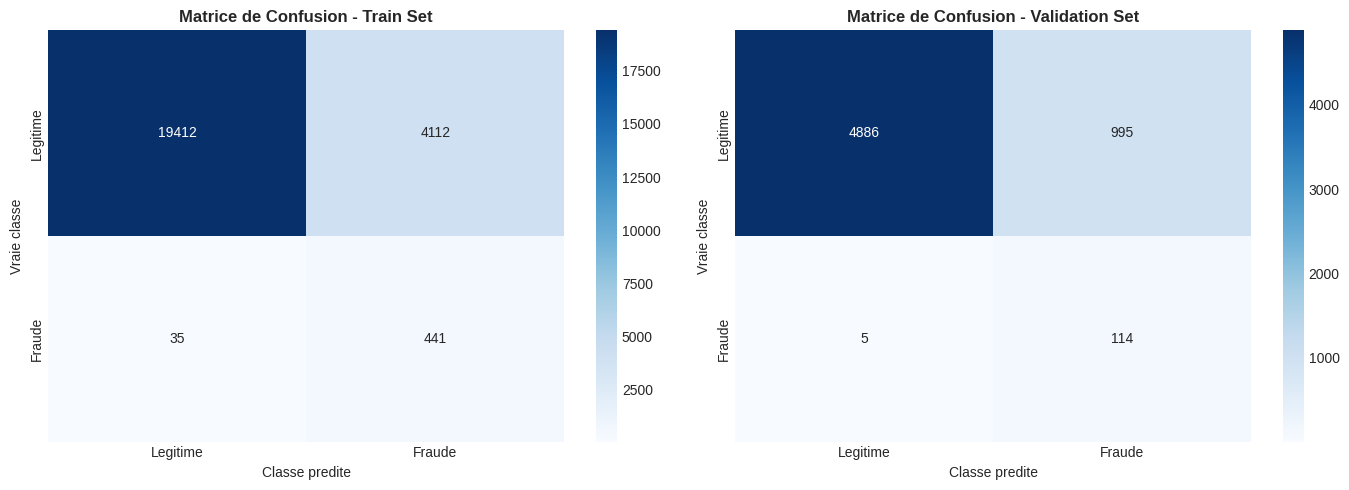


ANALYSE DE LA MATRICE DE CONFUSION (Validation):
   - Vrais Negatifs (TN): 4886 - Transactions legitimes correctement identifiees
   - Faux Positifs (FP): 995 - Transactions legitimes classees comme fraudes
   - Faux Negatifs (FN): 5 - Fraudes non detectees
   - Vrais Positifs (TP): 114 - Fraudes correctement detectees

   - Precision = TP/(TP+FP) = 114/1109 = 0.1028
   - Recall = TP/(TP+FN) = 114/119 = 0.9580

   - Faux Negatifs (FN) sont plus graves que Faux Positifs (FP)
     Car une fraude non detectee cause plus de dommages qu'une transaction legitime bloquee


In [9]:
# Matrices de confusion
cm_train = confusion_matrix(y_train, y_train_pred)
cm_val = confusion_matrix(y_val, y_val_pred)

print("=" * 60)
print("MATRICE DE CONFUSION")
print("=" * 60)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Legitime', 'Fraude'],
            yticklabels=['Legitime', 'Fraude'])
axes[0].set_title('Matrice de Confusion - Train Set', fontweight='bold')
axes[0].set_ylabel('Vraie classe')
axes[0].set_xlabel('Classe predite')

# Validation
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Legitime', 'Fraude'],
            yticklabels=['Legitime', 'Fraude'])
axes[1].set_title('Matrice de Confusion - Validation Set', fontweight='bold')
axes[1].set_ylabel('Vraie classe')
axes[1].set_xlabel('Classe predite')

plt.tight_layout()
plt.show()

# Analyse détaillée
print("\nANALYSE DE LA MATRICE DE CONFUSION (Validation):")
tn, fp, fn, tp = cm_val.ravel()
print(f"   - Vrais Negatifs (TN): {tn} - Transactions legitimes correctement identifiees")
print(f"   - Faux Positifs (FP): {fp} - Transactions legitimes classees comme fraudes")
print(f"   - Faux Negatifs (FN): {fn} - Fraudes non detectees")
print(f"   - Vrais Positifs (TP): {tp} - Fraudes correctement detectees")

print(f"\n   - Precision = TP/(TP+FP) = {tp}/{tp+fp} = {val_precision:.4f}")
print(f"   - Recall = TP/(TP+FN) = {tp}/{tp+fn} = {val_recall:.4f}")

print(f"\n   - Faux Negatifs (FN) sont plus graves que Faux Positifs (FP)")
print(f"     Car une fraude non detectee cause plus de dommages qu'une transaction legitime bloquee")


**Note :** Ce bloc affiche les matrices de confusion pour le train et la validation. La matrice de confusion montre les Vrais Positifs (TP), Vrais Négatifs (TN), Faux Positifs (FP), et Faux Négatifs (FN). Dans le contexte de la détection de fraude, les Faux Négatifs (fraudes non détectées) sont généralement plus graves que les Faux Positifs (transactions légitimes bloquées), car une fraude non détectée cause des pertes financières directes.


## 9. Courbe ROC


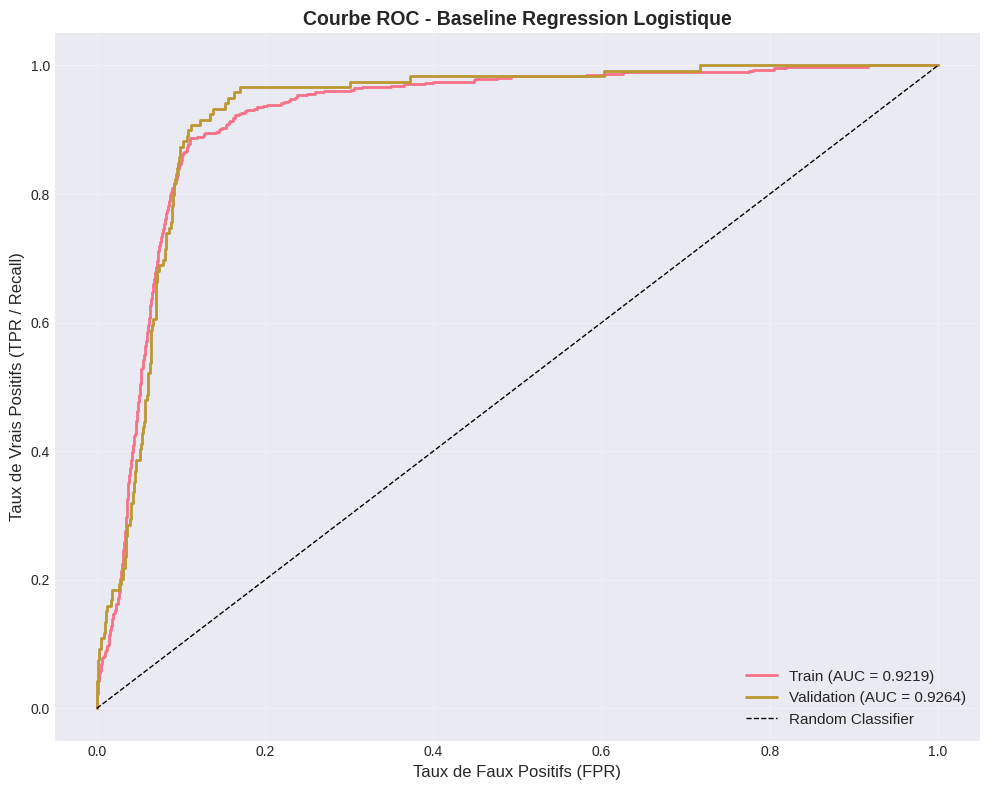

INTERPRETATION DE LA COURBE ROC

La courbe ROC montre la performance du modele a differents seuils de decision.
   - AUC = 0.9264 signifie que le modele peut distinguer les fraudes des transactions legitimes
   - Performance excellente (AUC > 0.8)


In [10]:
# Calcul des courbes ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)

# Visualisation
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {train_auc:.4f})', linewidth=2)
plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR / Recall)', fontsize=12)
plt.title('Courbe ROC - Baseline Regression Logistique', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 60)
print("INTERPRETATION DE LA COURBE ROC")
print("=" * 60)
print("\nLa courbe ROC montre la performance du modele a differents seuils de decision.")
print(f"   - AUC = {val_auc:.4f} signifie que le modele peut distinguer les fraudes des transactions legitimes")
if val_auc > 0.8:
    print("   - Performance excellente (AUC > 0.8)")
elif val_auc > 0.7:
    print("   - Performance acceptable (AUC > 0.7)")
else:
    print("   - Performance a ameliorer (AUC < 0.7)")


**Note :** Ce bloc trace la courbe ROC (Receiver Operating Characteristic) qui montre la performance du modèle à différents seuils de décision. L'AUC (Area Under Curve) mesure la capacité du modèle à distinguer les classes. Une AUC de 1.0 signifie une séparation parfaite, tandis qu'une AUC de 0.5 signifie que le modèle ne fait pas mieux qu'un classifieur aléatoire.


## 10. Importance des features


IMPORTANCE DES FEATURES (Coefficients)

Top 10 features les plus importantes:


,Feature,Coefficient,Abs_Coefficient
14,type_TRANSFER,1.217473,1.217473
8,amount_log,1.116544,1.116544
13,type_PAYMENT,-0.610168,0.610168
11,type_CASH_OUT,-0.570648,0.570648
9,amount_sqrt,0.523232,0.523232
6,is_night,0.248976,0.248976
5,is_weekend,0.236376,0.236376
1,amount,-0.192831,0.192831
3,day_of_week,-0.142205,0.142205
2,age,-0.140493,0.140493


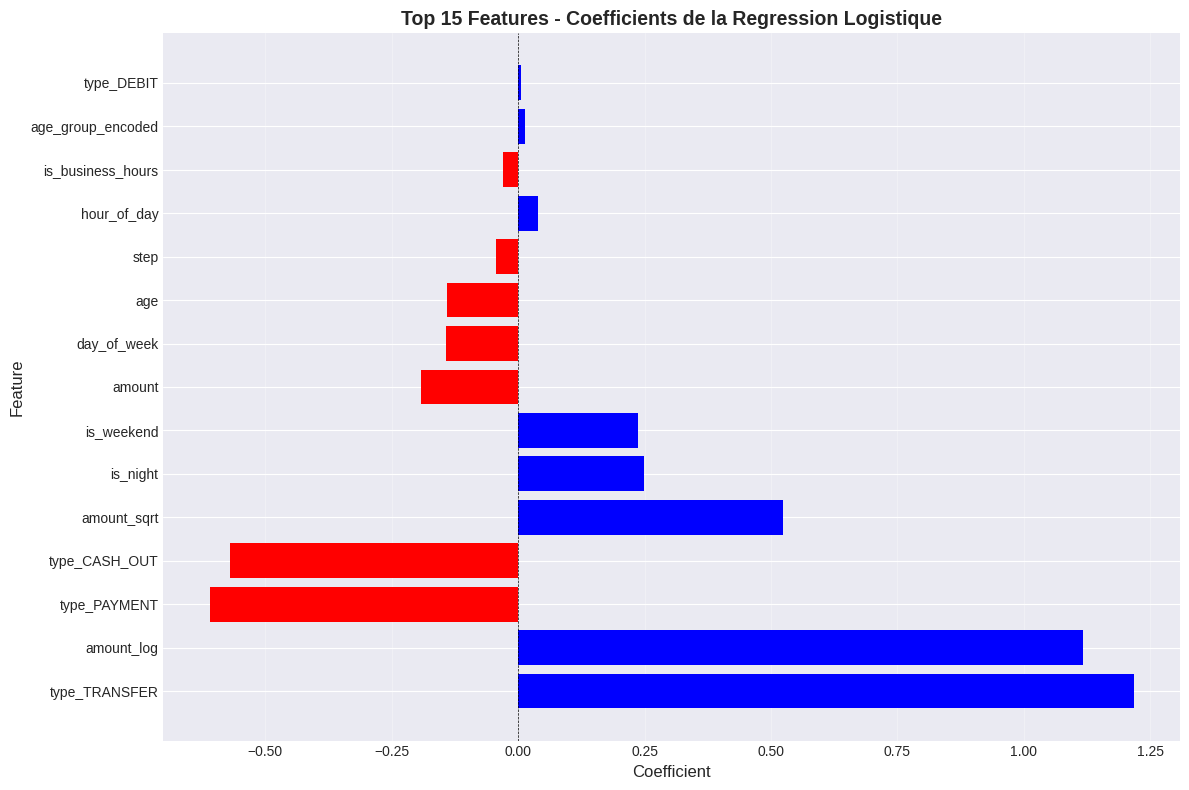


INTERPRETATION:
   - Coefficient positif: augmente la probabilite de fraude
   - Coefficient negatif: diminue la probabilite de fraude
   - Valeur absolue plus grande = feature plus importante


In [11]:
# Coefficients de la régression logistique (importance des features)
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': baseline_model.coef_[0],
    'Abs_Coefficient': np.abs(baseline_model.coef_[0])
})

feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("=" * 60)
print("IMPORTANCE DES FEATURES (Coefficients)")
print("=" * 60)
print("\nTop 10 features les plus importantes:")
display(feature_importance.head(10))

# Visualisation
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Features - Coefficients de la Regression Logistique', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("   - Coefficient positif: augmente la probabilite de fraude")
print("   - Coefficient negatif: diminue la probabilite de fraude")
print("   - Valeur absolue plus grande = feature plus importante")


**Note :** Ce bloc analyse l'importance des features en examinant les coefficients de la régression logistique. Les coefficients positifs indiquent que la feature augmente la probabilité de fraude, tandis que les coefficients négatifs la diminuent. La valeur absolue du coefficient indique l'importance relative de la feature. Cette analyse permet d'identifier quelles variables sont les plus prédictives pour la détection de fraude.


## 11. Rapport de classification détaillé


In [12]:
print("=" * 60)
print("RAPPORT DE CLASSIFICATION DETAILLE")
print("=" * 60)

print("\nRAPPORT SUR LE TRAIN SET:")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Legitime', 'Fraude']))

print("\nRAPPORT SUR LA VALIDATION SET:")
print(classification_report(y_val, y_val_pred, 
                          target_names=['Legitime', 'Fraude']))


RAPPORT DE CLASSIFICATION DETAILLE

RAPPORT SUR LE TRAIN SET:
              precision    recall  f1-score   support

    Legitime       1.00      0.83      0.90     23524
      Fraude       0.10      0.93      0.18       476

    accuracy                           0.83     24000
   macro avg       0.55      0.88      0.54     24000
weighted avg       0.98      0.83      0.89     24000


RAPPORT SUR LA VALIDATION SET:
              precision    recall  f1-score   support

    Legitime       1.00      0.83      0.91      5881
      Fraude       0.10      0.96      0.19       119

    accuracy                           0.83      6000
   macro avg       0.55      0.89      0.55      6000
weighted avg       0.98      0.83      0.89      6000



**Note :** Ce bloc affiche un rapport de classification détaillé qui montre la précision, le rappel, et le F1-Score pour chaque classe (légitime et fraude). Ce rapport permet d'identifier si le modèle a des difficultés particulières avec une classe et de comprendre les trade-offs entre précision et rappel.


## 12. Résumé et conclusions


In [13]:
print("=" * 60)
print("RESUME ET CONCLUSIONS - BASELINE")
print("=" * 60)

summary = {
    "Performance Baseline": {
        "F1-Score (Validation)": f"{val_f1:.4f}",
        "Precision": f"{val_precision:.4f}",
        "Recall": f"{val_recall:.4f}",
        "ROC-AUC": f"{val_auc:.4f}"
    },
    "Analyse": {
        "Gestion du desequilibre": "Utilisation de class_weight='balanced'",
        "Sur-apprentissage": "Faible" if abs(train_f1 - val_f1) < 0.05 else "Present",
        "Points forts": "Modele simple et interpretable, bon point de depart",
        "Points faibles": "Performance peut etre amelioree avec des modeles plus complexes"
    },
    "Prochaines etapes": {
        "1": "Tester d'autres modeles (Random Forest, XGBoost)",
        "2": "Feature engineering avance (interactions, aggregations)",
        "3": "Hyperparameter tuning",
        "4": "Techniques de re-echantillonnage (SMOTE)",
        "5": "Ensemble methods"
    }
}

for key, value in summary.items():
    print(f"\n{key}:")
    if isinstance(value, dict):
        for k, v in value.items():
            print(f"   - {k}: {v}")
    else:
        print(f"   {value}")

print("\n" + "=" * 60)
print("BASELINE TERMINEE")
print("=" * 60)
print(f"\nF1-Score Baseline (Validation): {val_f1:.4f}")
print("Ce score servira de reference pour comparer les modeles avances.")


RESUME ET CONCLUSIONS - BASELINE

Performance Baseline:
   - F1-Score (Validation): 0.1857
   - Precision: 0.1028
   - Recall: 0.9580
   - ROC-AUC: 0.9264

Analyse:
   - Gestion du desequilibre: Utilisation de class_weight='balanced'
   - Sur-apprentissage: Faible
   - Points forts: Modele simple et interpretable, bon point de depart
   - Points faibles: Performance peut etre amelioree avec des modeles plus complexes

Prochaines etapes:
   - 1: Tester d'autres modeles (Random Forest, XGBoost)
   - 2: Feature engineering avance (interactions, aggregations)
   - 3: Hyperparameter tuning
   - 4: Techniques de re-echantillonnage (SMOTE)
   - 5: Ensemble methods

BASELINE TERMINEE

F1-Score Baseline (Validation): 0.1857
Ce score servira de reference pour comparer les modeles avances.


**Note :** Ce bloc final résume les résultats de la baseline. Le F1-Score obtenu sur la validation sert de référence pour comparer les modèles plus avancés. Il identifie également les points forts et faibles du modèle baseline et suggère les prochaines étapes pour améliorer les performances.
